#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Изначально данные у нас поделены на интервал по 10 минут, это не совсем удобно для предсказания на последующий час спроса такси, поэтому сделаем ресемплирование

In [5]:
df = df.resample('1H').sum()
display(df.head(10))
display(len(df))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


4416

Данные на базе, теперь их нужно изучить. Что ж приступим к изучению

## Анализ

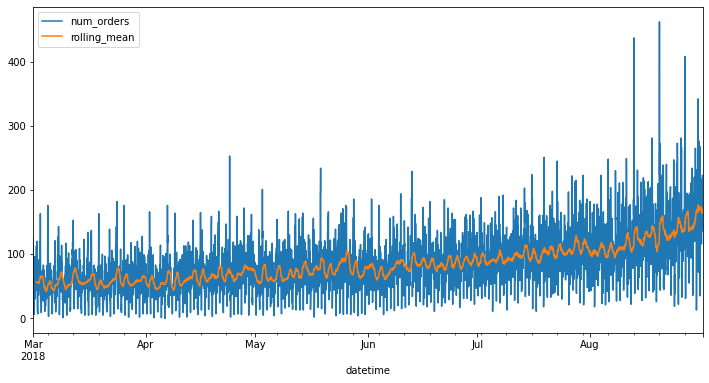

In [6]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot(figsize=(12, 6))

У нас есть исторические данные с марта 2018 по август 2018. В конце мая мы видим скачек заявок, лето это всегда сезон отпусков. Также начиная с первой половины июня кол-во заявок растем самые пиковые значения у нас под конец августа. Это похоже на трен. Посмотрим как выглядит наш тред и сезонность.

In [7]:
df = df.drop(['rolling_mean'], axis=1)

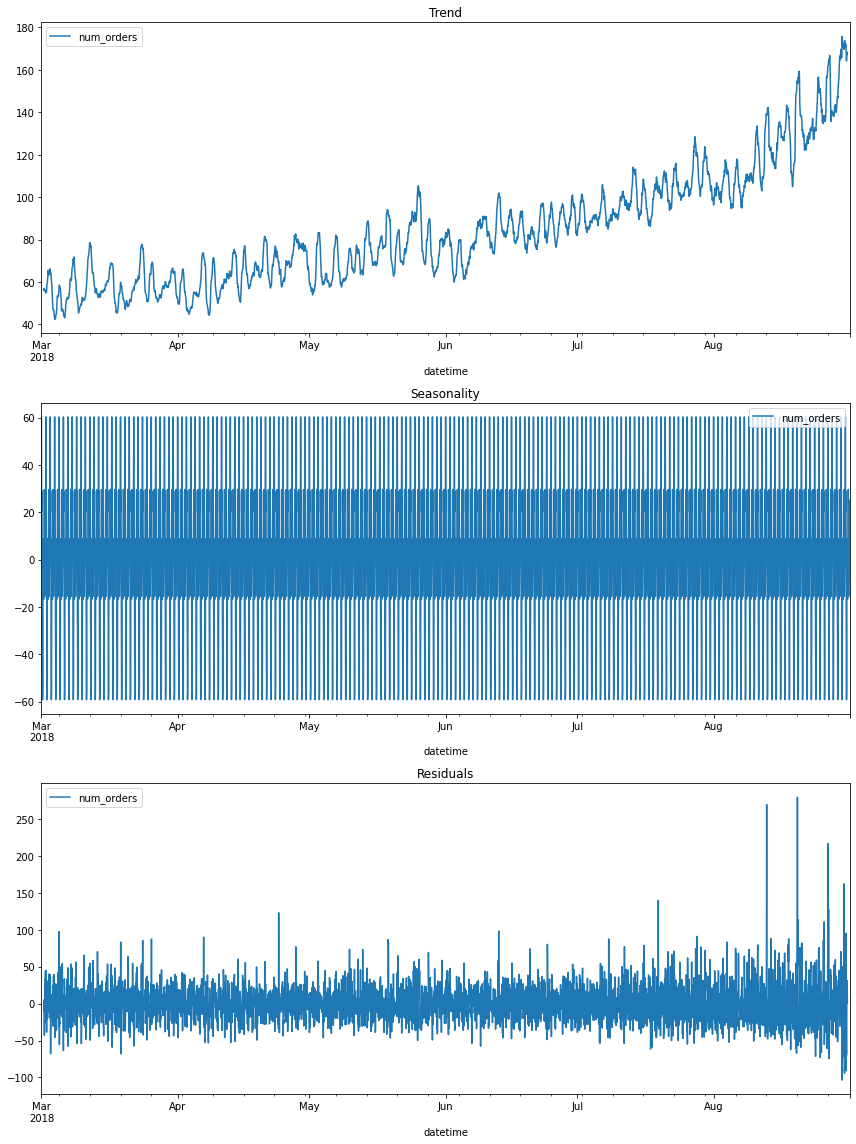

In [8]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд можно объяснить тем, что лето это теплое время года и все стараются взять отпуск именно в это время. Как провести лучше всего отпуск? Конечно же отправиться в путешестие! Именно поэтому и появляется наш тренд. С сезонностью не так все просто, предположим, что она есть в течение дня, поэтому данные график не совсем читабильный. Изучим его отдельно. Остакти иторнпретировать сложно.

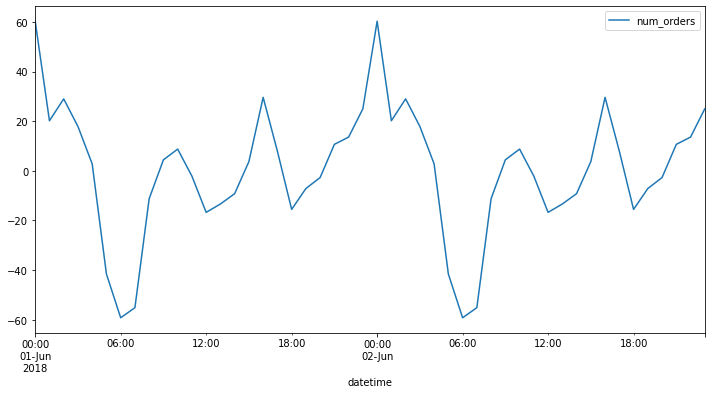

In [9]:
decomposed.sesonal = decomposed.seasonal['2018-06-01':'2018-06-02']
decomposed.sesonal.plot(figsize=(12,6))

Так уже лучше! Наша сезонность зависит от времени! Предположим, что она зависим и от дня недели.

## Обучение

Создадим признаки для нашей модели

Напишем функцию для создания новых признаков. Как мы уже выяснили на сезонность влияют день недели и время дня, поэтому добавим новый признак день недели, сделаем 2 смещения и добавим скользящее среднее с окном 24 и стандартное отклонение с окном 24.

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['rolling_std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()

In [11]:
make_features(df, 24, 24)

Разделим данные на тренировочную и тестовыю выборки. Для тестовой выборки оставим 10%

In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [13]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(3950, 27) (442, 27) (3950,) (442,)


Для оценки наших моделей будем использовать метрику RMSE(среднеквадратичное отклонение)

In [14]:
def RMSE(target, predict):
    return mean_squared_error(target,predict)**0.5

In [15]:
score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [16]:
LinearReg_model = LinearRegression()

In [17]:
%%time
LinearReg_model.fit(features_train, target_train)

CPU times: user 9.19 ms, sys: 7.12 ms, total: 16.3 ms
Wall time: 30.5 ms


LinearRegression()

In [18]:
%%time
LinReg_pred = LinearReg_model.predict(features_train)

CPU times: user 6.09 ms, sys: 12.5 ms, total: 18.6 ms
Wall time: 17 ms


In [19]:
print('RMSE: ', RMSE(target_train, LinReg_pred).round(2))

RMSE:  25.92


### Catboost

In [20]:
Catboost_model = CatBoostRegressor(verbose = 10, random_seed = 29)

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
param_grid = {'iterations': [10, 50], 'max_depth': [5, 15]}

In [23]:
grid_cv = GridSearchCV(Catboost_model, param_grid, scoring=score, cv=tscv)

In [24]:
%%time
grid_cv.fit(features_train, target_train, verbose=False)

CPU times: user 14min 2s, sys: 7min 12s, total: 21min 14s
Wall time: 11min 13s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1c6e11c5d0>,
             param_grid={'iterations': [10, 50], 'max_depth': [5, 15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [25]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-26.462029801671584
{'iterations': 50, 'max_depth': 5}


In [26]:
Catboost_model = CatBoostRegressor(verbose = 10, iterations = 50, max_depth = 5)

In [27]:
%%time
Catboost_model.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 32.1484086	total: 5.19ms	remaining: 254ms
10:	learn: 23.7121186	total: 48.4ms	remaining: 172ms
20:	learn: 21.7873015	total: 89.5ms	remaining: 124ms
30:	learn: 20.1292890	total: 134ms	remaining: 82.1ms
40:	learn: 18.8977507	total: 180ms	remaining: 39.4ms
49:	learn: 17.9032298	total: 226ms	remaining: 0us
CPU times: user 437 ms, sys: 13.5 ms, total: 451 ms
Wall time: 277 ms


In [28]:
%%time
Catboost_pred = Catboost_model.predict(features_train)

CPU times: user 4.6 ms, sys: 0 ns, total: 4.6 ms
Wall time: 7.75 ms


In [29]:
print('RMSE: ', RMSE(target_train, Catboost_pred).round(2))

RMSE:  17.9


### LGBM

In [30]:
LGBM_model = LGBMRegressor(random_state = 29, n_job=-1)

In [31]:
LGBM_model

LGBMRegressor(n_job=-1, random_state=29)

In [32]:
param_grid = {'n_estimators': [100, 1000], 'max_depth': [5, 15]}

In [33]:
grid_cv = GridSearchCV(LGBM_model, param_grid, scoring=score, cv=tscv)

In [34]:
%%time
grid_cv.fit(features_train, target_train, verbose=True)

CPU times: user 33.7 s, sys: 773 ms, total: 34.5 s
Wall time: 17.7 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_job=-1, random_state=29),
             param_grid={'max_depth': [5, 15], 'n_estimators': [100, 1000]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [35]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-25.575740877893118
{'max_depth': 5, 'n_estimators': 100}


In [36]:
LGBM_model = LGBMRegressor(random_state = 29, max_depth= 5, n_estimators= 100, n_job=-1)

In [37]:
%%time
LGBM_model.fit(features_train, target_train)

CPU times: user 371 ms, sys: 4.36 ms, total: 375 ms
Wall time: 206 ms


LGBMRegressor(max_depth=5, n_job=-1, random_state=29)

In [38]:
%%time
LGBM_pred = LGBM_model.predict(features_train)

CPU times: user 40.5 ms, sys: 2.78 ms, total: 43.3 ms
Wall time: 29.1 ms


In [39]:
print('RMSE: ', RMSE(target_train, LGBM_pred).round(2))

RMSE:  16.5


## Тестирование

### LinearRegression

In [40]:
%%time
LinReg_pred = LinearReg_model.predict(features_test)

CPU times: user 3.6 ms, sys: 813 µs, total: 4.41 ms
Wall time: 6.74 ms


In [41]:
print('RMSE: ', RMSE(target_test, LinReg_pred).round(2))

RMSE:  45.01


### Catboost

In [42]:
%%time
Catboost_pred = Catboost_model.predict(features_test)

CPU times: user 8.51 ms, sys: 7.83 ms, total: 16.3 ms
Wall time: 16.9 ms


In [43]:
print('RMSE: ', RMSE(target_test, Catboost_pred).round(2))

RMSE:  44.63


### LGBM

In [44]:
%%time
LGBM_pred = LGBM_model.predict(features_test)

CPU times: user 15.1 ms, sys: 5.1 ms, total: 20.2 ms
Wall time: 16 ms


In [45]:
print('RMSE: ', RMSE(target_test, LGBM_pred).round(2))

RMSE:  43.0


## Вывод

In [2]:
result=pd.DataFrame({'Модель':['LinearRegression', 'CatBoost', 'LGBM'],
 'Скорость подбора гиперпараметров':['Гиперпараметров нет', '11 мин 13 сек', '17,7 сек'],
 'Скорость обучения':['30,5 мсек', '277 мсек', '206 сек'],
 'Скорость предсказания': ['6,74 мсек', '16,9 мсек', '16 мсек'],
 'Качество предсказания(RMSE)': ['45,01', '44,63', '43']})
result

,Модель,Скорость подбора гиперпараметров,Скорость обучения,Скорость предсказания,Качество предсказания(RMSE)
0,LinearRegression,Гиперпараметров нет,"30,5 мсек","6,74 мсек","45,01"
1,CatBoost,11 мин 13 сек,277 мсек,"16,9 мсек","44,63"
2,LGBM,"17,7 сек",206 сек,16 мсек,43


По результатам исследования мы подобрали модель для предсказания спроса такси на один час. Лучшей моделью мы получили градиентный бустинг LGBM. Но так как мы предлагаем модель для действующего бизнеса, то наша рекомендация использовать простую модель линейной регресси, она показала хороший результат и в дальнейшем данную модель будет не сложно поддерживать и обновлять.